<a href="https://colab.research.google.com/github/amandaswens/DSPS_ASwenson/blob/main/HW10/HW10_DSPS2025_deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDreaming with TensorFlow

# modified by FBB (@fedhere) for UD DSPS 2019 class  updated for DEPS2021 including upgrading to python3 and current version of TF
# updated for PUS2022
# updated for MLTSA 2024 USPS 2025

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

###  Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [ ]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
import pylab as pl
import scipy.ndimage
import math

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.compat.v1.InteractiveSession(graph=graph)
with tf.compat.v2.io.gfile.GFile(model_fn, 'rb') as f:

    graph_def = tf.compat.v1.GraphDef()   # -> instead of tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.compat.v1.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip


ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


make sure you are running on the GPUs - on the notebook menu go to

Runtime\-\>Change Runtime type




In [ ]:
!wget https://raw.githubusercontent.com/fedhere/FDSFE_FBianco/refs/heads/main/runtime.png

--2025-11-20 03:15:06--  https://raw.githubusercontent.com/fedhere/FDSFE_FBianco/refs/heads/main/runtime.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50464 (49K) [image/png]
Saving to: ‘runtime.png’

runtime.png         100%[===================>]  49.28K  --.-KB/s    in 0.001s  

2025-11-20 03:15:06 (54.1 MB/s) - ‘runtime.png’ saved [50464/50464]



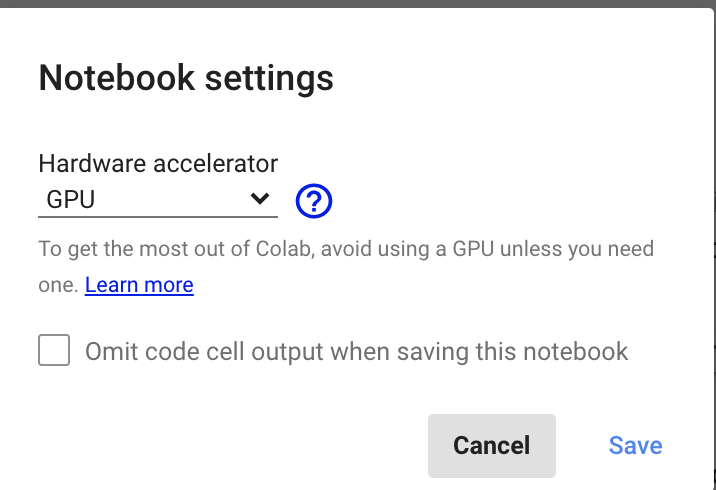

In [ ]:
from IPython.display import Image
Image(filename='runtime.png')

In [ ]:
def showarray(a, fmt='jpeg'):
    #if a is > 3 axis cut the last one assuming its alpha-transparency
    if a.shape[-1] == 4:
      a = a[:,:,:3]
    elif len(a.shape) < 3:
      a = a[:,:,:,np.ones,like(a[0])]
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))



# Task 1: Create a random noise "image":
an array of 300x300 pixels and 3 color channels (RGB). Fill it in with random noise but make sure the values are Unsigned integer 8bit type (np.unit8) and contained between 0 and 255. This is how a jpg image would be encoded in python and both pylab and this base code require this encoding for the image.  This can be achieved by generating random uniform noise (between 0 and 1) and convert it to 0-255 by multiplication, then convert the data type

In [ ]:
noise_img = (np.random.rand(300,300,3)*255).astype(np.uint8)

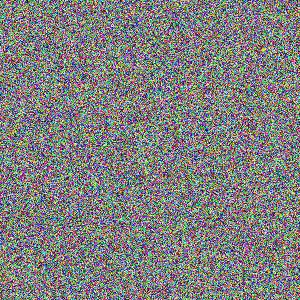

(300, 300, 3)

In [ ]:
#create a 300x300x3 array that contains gaussian noise only = np.randn() can be used to create the gaussian noise
showarray(noise_img)
noise_img.shape

## This cell defines functions and variable that will be used by the pre-trained model. We also define a function that reshapes an image to make sure it is compatible with the input that the model needs (300x300x3 unsigned integer type)

In [ ]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.compat.v1.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

# Task 2 start a deep dream and explore!:

Adjust the sliders to change the strength of the deep dream, and how many scales it is applied over and until you obtain a "phsychadelic" result that you like

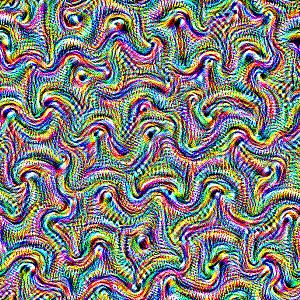

In [ ]:
octave_n = 2 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 30 #@param {type:"slider", max: 50}
strength = 821 #@param {type:"slider", max: 1000}
layer = "mixed4c"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), noise_img)


 # Task 3 pull each layer:
 look at the list of layers. In the following cells plot 6 of the relevant layers: pick layers that start with "mixed"  (I give you an example with a layer called `head0_bottleneck_pre_relu` and a layer called `mixed5a_pool_reduce_pre_relu`)

In [ ]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

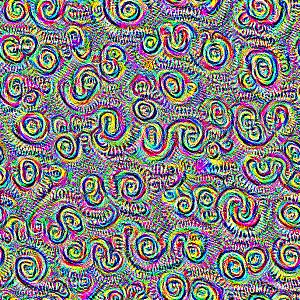

In [ ]:
layer = "head0_bottleneck_pre_relu"
final = render_deepdream(tf.square(T(layer)), noise_img)

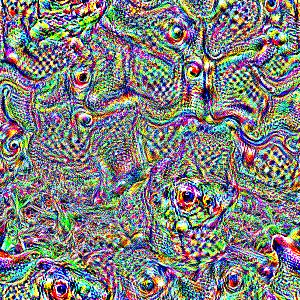

In [ ]:
layer = "mixed5a_pool_reduce_pre_relu"
final = render_deepdream(tf.square(T(layer)), noise_img)

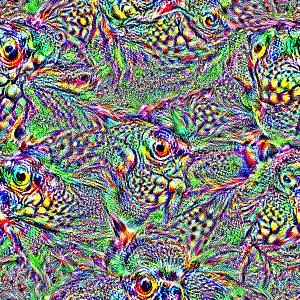

In [ ]:
layer = "mixed4e_pool_reduce_pre_relu/conv"
final = render_deepdream(tf.square(T(layer)), noise_img)

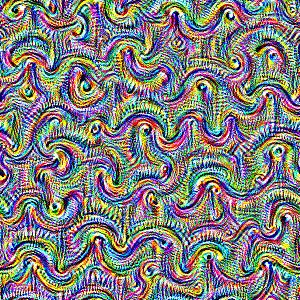

In [ ]:
layer = "mixed4c_5x5_bottleneck_pre_relu/conv"
final = render_deepdream(tf.square(T(layer)), noise_img)

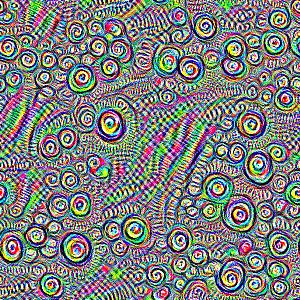

In [ ]:
layer = "mixed4a_1x1_pre_relu/conv"
final = render_deepdream(tf.square(T(layer)), noise_img)

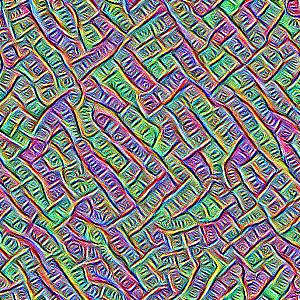

In [ ]:
layer = "mixed3a_3x3_bottleneck_pre_relu/conv"
final = render_deepdream(tf.square(T(layer)), noise_img)

# Task 4:  Qalitatively describe
based on your understanding and reading, why the layers show different features and what it the "kind" of features extracted in the earler layers vs the later ones.


**Layers:**

1.   The first image implies that less computations were made to form the image given no animals have been formed yet. Given this information, we can assume it is an earlier layer.
2.   In the second image shows more complexity - we begin to see what looks like eyes (maybe) of some sort of reptile suggesting this is a later layer.
3. The third image looks very similar to the second. You can see some organisims start to form with repitliian-looking scales and eyes scattered around the image.
4. Back to the swirls in the fourth image. However this is a different verison of the swirls we saw in #1. This time it is less complex given there is less going on suggesting it is an earlier layer.
5. #5 is also similar to #1 and #4. There's still no organisims present - just swirls, though you can see what looks like the start of some scales forming in the background suggesting this is an intermediate layer.
6. #6 is interesting; no swirls, but rather something plant like. It almost looks like when you stare real close at a leaf and you see the vascular system of the plant. I would conclude this is an intermediate layer as well.

**Why**:
Different layers highlight different features because CNNs learn visuals hierarchically. Early layers only detect simple edges and colors, so the dreams look mostly like noisy patterns. Middle layers combine edges into textures like fur or spirals, giving more psychedelic shapes. Later layers detect object-level features (like faces or buildings), so the image starts filling with recognizable objects. It's amplifying statistical patterns it learned during training.



# Task 5: Load your chosen image
Choose an image that you like and transform it: must be at least 600 pixels in both x and y axis and must be a color jpg  image (wont work with png I think)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving colors.jpg to colors.jpg


In [ ]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[list(uploaded.keys())[0]]


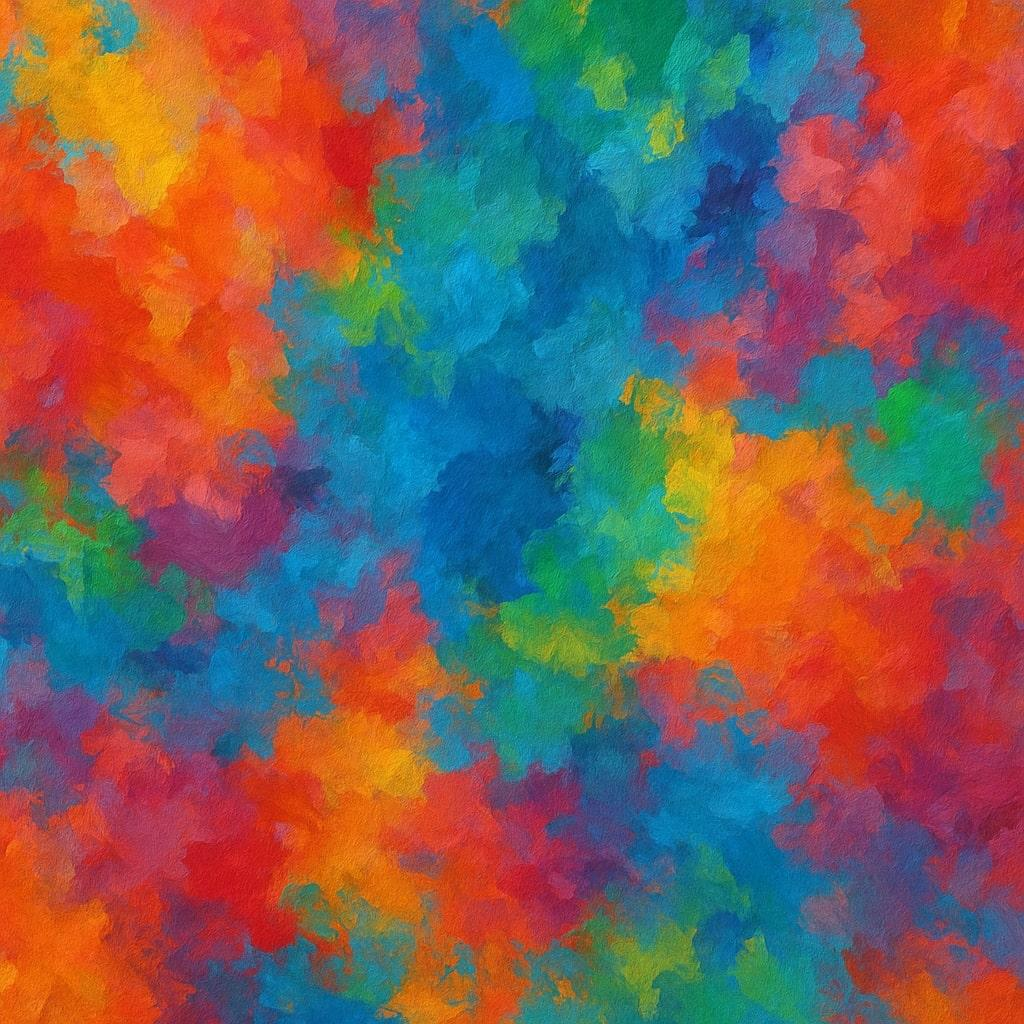

In [ ]:
img0 = sess.run(tf.io.decode_image(file_contents))
showarray(img0)


# Task 6: shrink it to 600 pixels along the x axis by subsampling


In [ ]:
img0.shape

(1024, 1024, 3)

In [ ]:
basewidth = 600
img1 = img0.copy()

if img1.shape[0] > basewidth:
    step_y = math.ceil(img1.shape[0] / basewidth)
    img1 = img1[::step_y, :, :]

if img1.shape[1] > basewidth:
    step_x = math.ceil(img1.shape[1] / basewidth)
    img1 = img1[:, ::step_x, :]

zoom_y = basewidth / img1.shape[0]
zoom_x = basewidth / img1.shape[1]
img1 = scipy.ndimage.zoom(img1, zoom=(zoom_y, zoom_x, 1), order=1)


In [ ]:
tf.io.decode_image(file_contents)

<tf.Tensor 'decode_image_1/DecodeImage:0' shape=<unknown> dtype=uint8>

In [ ]:
img1.shape

(600, 600, 3)

# Task 7: Repeat step 3, DeepDream, with your image.
Save the layer you like. Upload tha original and modified image to the readme file of your DSPS repo



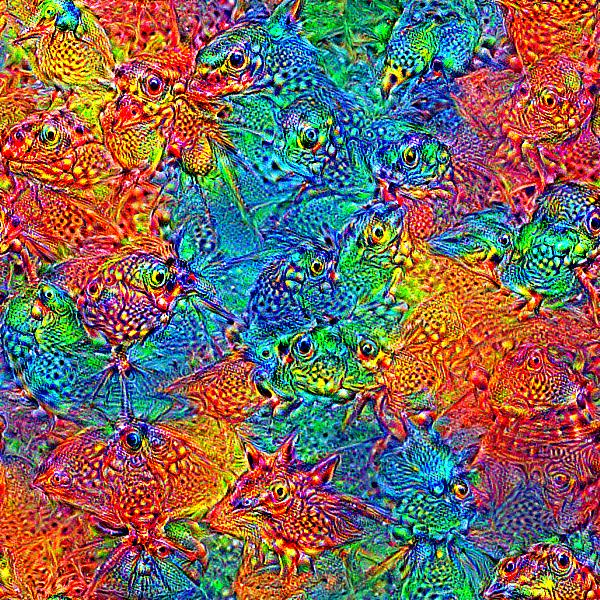

In [ ]:
layer = "mixed4e_pool_reduce_pre_relu/conv"
final = render_deepdream(tf.square(T(layer)), img1)

# Task 8: Answer: Are there "animals" in your image? why? (there should be)
**Response:** There are definitely animals in my image. I can clearly make out chicken-like shapes, insects, and even a goose-looking thing. These appear because the neural network has been trained on huge labeled datasets that contain tons of animals, so many of its higher-level feature detectors activate on animal parts.

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe

## Optional: Diving deeper into the Inception Model

Lets look a bit deeper into the Inception Model and visualize the layers. Each layer will produce a very different result when used in deep dreaming.

In [ ]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

For example try deepdreaming with the layer '`mixed4a_3x3_pre_relu`'

In [ ]:
layer = "mixed5b_pool_reduce_pre_relu"
final = render_deepdream(tf.square(T(layer)), img1)

We can also use TensorBoard to visualize the full graph to understand better how these different layers relate to each other. Most of the code in the next section just makes the graph look a little bit cleaner.

In [ ]:

# Helper functions for TF Graph visualization
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.compat.v1.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def rename_nodes(graph_def, rename_func):
    res_def = tf.compat.v1.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add()
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
tmp_def

In [ ]:

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their
# internal structure. We are going to visualize "Conv2D" nodes.
show_graph(graph_def)